### Титаник.

Домашнее задание.

In [37]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingClassifier

###  Данные

Прочитаем тренировочные и тестовые данные.

In [36]:
train = pd.read_csv('titanic/train.csv')
test  = pd.read_csv('titanic/test.csv')

In [740]:
est = smf.ols('Survived ~ Age + Fare + Pclass + Sex', train).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     113.4
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           9.83e-75
Time:                        00:27:42   Log-Likelihood:                -328.83
No. Observations:                 714   AIC:                             667.7
Df Residuals:                     709   BIC:                             690.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3169      0.077     17.104      0.000       1.166       1.468
Sex[T.male]    -0.4787      0.031    -15.518      0.000      -0.539      -0.418
Age            -0.0054      0.001     -4.975      0.000      -0.008      -0.003
Fare         6.801e-05      0.000      0.205      0.838      -0.001       0.001
Pclass         -0.2004      0.023     -8.907      0.000      -0.245      -0.156
==============================================================================
Omnibus:                       24.788   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.676
Skew:                           0.473   Prob(JB):                     1.61e-06
Kurtosis:                       3.046   Cond. No.                         365.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [737]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [269]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
is_test        418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


### Feature еngeneering

Создаем и описываем фичи.
Чтобы не дублировать операции для тренировочной тестовой выборки, объединим их:
- удалим целевой столбеци из train
- добавим флаг тестовой выборки
- проверим, что что поля совпадают.

In [14]:
# Прочитаем данные еще раз
train = pd.read_csv('titanic/train.csv')
test  = pd.read_csv('titanic/test.csv')

y_train = train.Survived
# Удалим целевую функцию из train
train.drop('Survived',axis=1,inplace=True)
# Пометим выборки
train['is_test'] = 0
test['is_test'] = 1
# Склеим
df = pd.concat([train,test])
# Заменим пол со строковой переменной на числовую
df['IsMale'] = df.Sex.replace({'male':1, 'female':0})
#Давим фичу HaveCabin - проверим у кого указана каюта.
#df['HaveCabin'] = df.Cabin.isnull()
#df.HaveCabin.replace({True : 1, False : 0},inplace=True)
get_titles(df)
process_age(df)
process_ticket(df)
process_family(df)
process_cabin(df)

In [1014]:
#df.info()

In [1015]:
#df.head()

In [901]:
grouped = df.groupby(['Sex','Pclass','Title'])
grouped_median = grouped.median()

In [791]:
#df['FareLog'] = df.Fare.apply(np.log) 
#df.FareLog[df.Fare == 0] = 0

In [792]:
#plt.figure(figsize=(10, 6))
#plt.scatter(df.Age, df.FareLog, facecolors='None', edgecolors='grey') 

In [678]:
#clf = gs.best_estimator_
#clf.fit(df_have_age_d_i_s, y_age)
#y_pred = clf.predict(df_have_age_d_i_s)
#for i,j in zip(y_age, y_pred):
    #print ("{}  {}".format(i,j))

In [902]:
df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_test', 'IsMale', 'HaveCabin',
       'Title'],
      dtype='object')

In [930]:
df_est = df.copy()
df_est = df_est[df_est.is_test == 0].drop('is_test',axis = 1)
df_est = pd.get_dummies(df_est, columns=['Pclass',])
df_est['Survived'] = y_train
#df_est.head()
df_est.columns

Index(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'IsMale', 'HaveCabin', 'Title', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Survived'],
      dtype='object')

In [932]:
#df_est.info()
est = smf.ols('Survived ~ Age + Pclass_1 + Pclass_2 + IsMale + SibSp + Title + HaveCabin', df_est).fit()
est.summary()
#df_est.head()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     62.99
Date:                Thu, 16 Nov 2017   Prob (F-statistic):          4.44e-103
Time:                        02:22:48   Log-Likelihood:                -363.02
No. Observations:                 891   AIC:                             750.0
Df Residuals:                     879   BIC:                             807.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4166      0.259      5.470      0.000       0.908       1.925
Title[T.Miss]       -0.5878      0.261     -2.254      0.024      -1.100      -0.076
Title[T.Mr]         -0.4899      0.071     -6.894      0.000      -0.629      -0.350
Title[T.Mrs]        -0.4885      0.263     -1.858      0.064      -1.005       0.028
Title[T.Officer]    -0.4960      0.117     -4.252      0.000      -0.725      -0.267
Title[T.Royalty]    -0.4764      0.207     -2.303      0.021      -0.882      -0.070
Age                 -0.0042      0.001     -3.469      0.001      -0.007      -0.002
Pclass_1             0.2762      0.052      5.327      0.000       0.174       0.378
Pclass_2             0.1578      0.033      4.787      0.000       0.093       0.222
IsMale              -0.6049      0.251     -2.407      0.016      -1.098      -0.112
SibSp               -0.0780      0.012     -6.369      0.000      -0.102      -0.054
HaveCabin           -0.1143      0.048     -2.359      0.019      -0.209      -0.019
==============================================================================
Omnibus:                       43.469   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.266
Skew:                           0.531   Prob(JB):                     2.01e-11
Kurtosis:                       3.445   Cond. No.                     1.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
df_dummies = pd.get_dummies(df, columns=['Pclass','Title','Embarked'])
#df_dummies = pd.get_dummies(df, columns=['Pclass','Embarked'])

#df_dummies.head()
df_dummies.drop(['PassengerId','Name','Sex','Ticket','Cabin'],axis=1,inplace=True)
# Разделим тренировочную и тестовую выборку.

X_train = df_dummies[df_dummies.is_test == 0].drop('is_test',axis = 1)
X_test = df_dummies[df_dummies.is_test == 1].drop('is_test', axis = 1)

# Заполнение пустых значений
columns = X_train.columns
imputer = Imputer(missing_values='NaN', strategy='mean', axis = 0, verbose=1, copy = True)
imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

X_test_imputed = imputer.transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=columns)

# Нормировка значений
scaler = StandardScaler()
scaler.fit(X_train_imputed)
X_train_i_s = scaler.transform(X_train_imputed)
X_train_i_s = pd.DataFrame(X_train_i_s, columns = columns)

# Заполним тестовую выборку
X_test_i_s = scaler.transform(imputer.transform(X_test))
X_test_i_s = pd.DataFrame(X_test_i_s, columns = columns)

In [16]:
X_train_i_s.head()

,Age,SibSp,Parch,Fare,IsMale,FamilySize,Singleton,SmallFamily,LargeFamily,Pclass_1,...,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,-0.531932,0.432793,-0.473674,-0.502445,0.737695,0.059160,-1.231645,1.432260,-0.273476,-0.565685,...,0.902587,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.075122,-0.482043,-0.307562,0.619306
1,0.648857,0.432793,-0.473674,0.786845,-1.355574,0.059160,-1.231645,1.432260,-0.273476,1.767767,...,-1.107926,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.075122,2.074505,-0.307562,-1.614710
2,-0.236735,-0.474545,-0.473674,-0.488854,-1.355574,-0.560975,0.811922,-0.698197,-0.273476,-0.565685,...,0.902587,-0.216803,1.960202,-1.175735,-0.407714,-0.143592,-0.075122,-0.482043,-0.307562,0.619306
3,0.427459,0.432793,-0.473674,0.420730,-1.355574,0.059160,-1.231645,1.432260,-0.273476,1.767767,...,-1.107926,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.075122,-0.482043,-0.307562,0.619306
4,0.427459,-0.474545,-0.473674,-0.486337,0.737695,-0.560975,0.811922,-0.698197,-0.273476,-0.565685,...,0.902587,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.075122,-0.482043,-0.307562,0.619306


# Boost

In [34]:
best_gboost_clf = get_gboost_best_model(X_train_i_s, y_train, 'accuracy',50)

Best score 1 (accuracy):0.8148148148148148 
Best score subsample (accuracy):0.813692480359147 
Best score max_depth (accuracy):0.8226711560044894 
Best score learning_rate (accuracy):0.8249158249158249 


In [35]:
clf = GradientBoostingClassifier(**best_gboost_clf)
clf.fit(X_train_i_s,y_train)
y_test = clf.predict(X_test_i_s)
submit = pd.DataFrame(test.PassengerId)
submit['Survived'] = y_test
submit.to_csv('submit.csv', index = False)
clf.score(X_train_i_s,y_train)

0.90235690235690236

 ## XGBoost

In [20]:
best_xgboost_clf = get_xgboost_best_model(X_train_i_s, y_train,'accuracy')

Best score 1 (accuracy):0.8282828282828283 
Fitting 2 folds for each of 21 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   21.0s finished


Best score 2 (accuracy):0.8260381593714927 
Best score 3 (accuracy):0.8271604938271605 
Best score 4 (accuracy):0.8451178451178452 
Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.7s finished


Best score 5 (accuracy):0.8170594837261503 
Best score 6:  0.830513427722


In [25]:
clf = xgboost.XGBClassifier(**best_xgboost_clf)
clf.fit(X_train_i_s,y_train)
y_test = clf.predict(X_test_i_s)
submit = pd.DataFrame(test.PassengerId)
submit['Survived'] = y_test
submit.to_csv('submit.csv', index = False)
clf.score(X_train_i_s,y_train)

0.89001122334455662

In [22]:
gboost_clf = GradientBoostingClassifier(**best_gboost_clf)
xgboost_clf = xgboost.XGBClassifier(**best_xgboost_clf)
clfs = [gboost_clf, xgboost_clf]

X_train_np = np.array(X_train_i_s)
X_test_np = np.array(X_test_i_s)
y_train_np = np.array(y_train)
predicted = [cross_val_predict_proba(est, X_train_np, y_train_np, X_test_np) for est in clfs]
X_train_stack = np.stack([p[0] for p in predicted], axis=1)
X_test_stack = np.stack([p[1] for p in predicted], axis=1)

cv = KFold(shuffle=True, n_splits=2)
params = {'class_weight': ['balanced', None],
          'penalty': ['l1', 'l2'],
          'C': [0.4, 0.5, 1., 2., 2.5, 3., 3.5, 4.]}
grid = GridSearchCV(LogisticRegression(), params, scoring='neg_log_loss', cv=cv)
grid.fit(X_train_stack, y_train)

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'class_weight': ['balanced', None], 'penalty': ['l1', 'l2'], 'C': [0.4, 0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [23]:
clf = grid.best_estimator_
clf.fit(X_train_stack,y_train)
y_test = clf.predict(X_test_stack)
submit = pd.DataFrame(test.PassengerId)
submit['Survived'] = y_test
submit.to_csv('submit.csv', index = False)
clf.score(X_train_stack,y_train)

0.88664421997755327

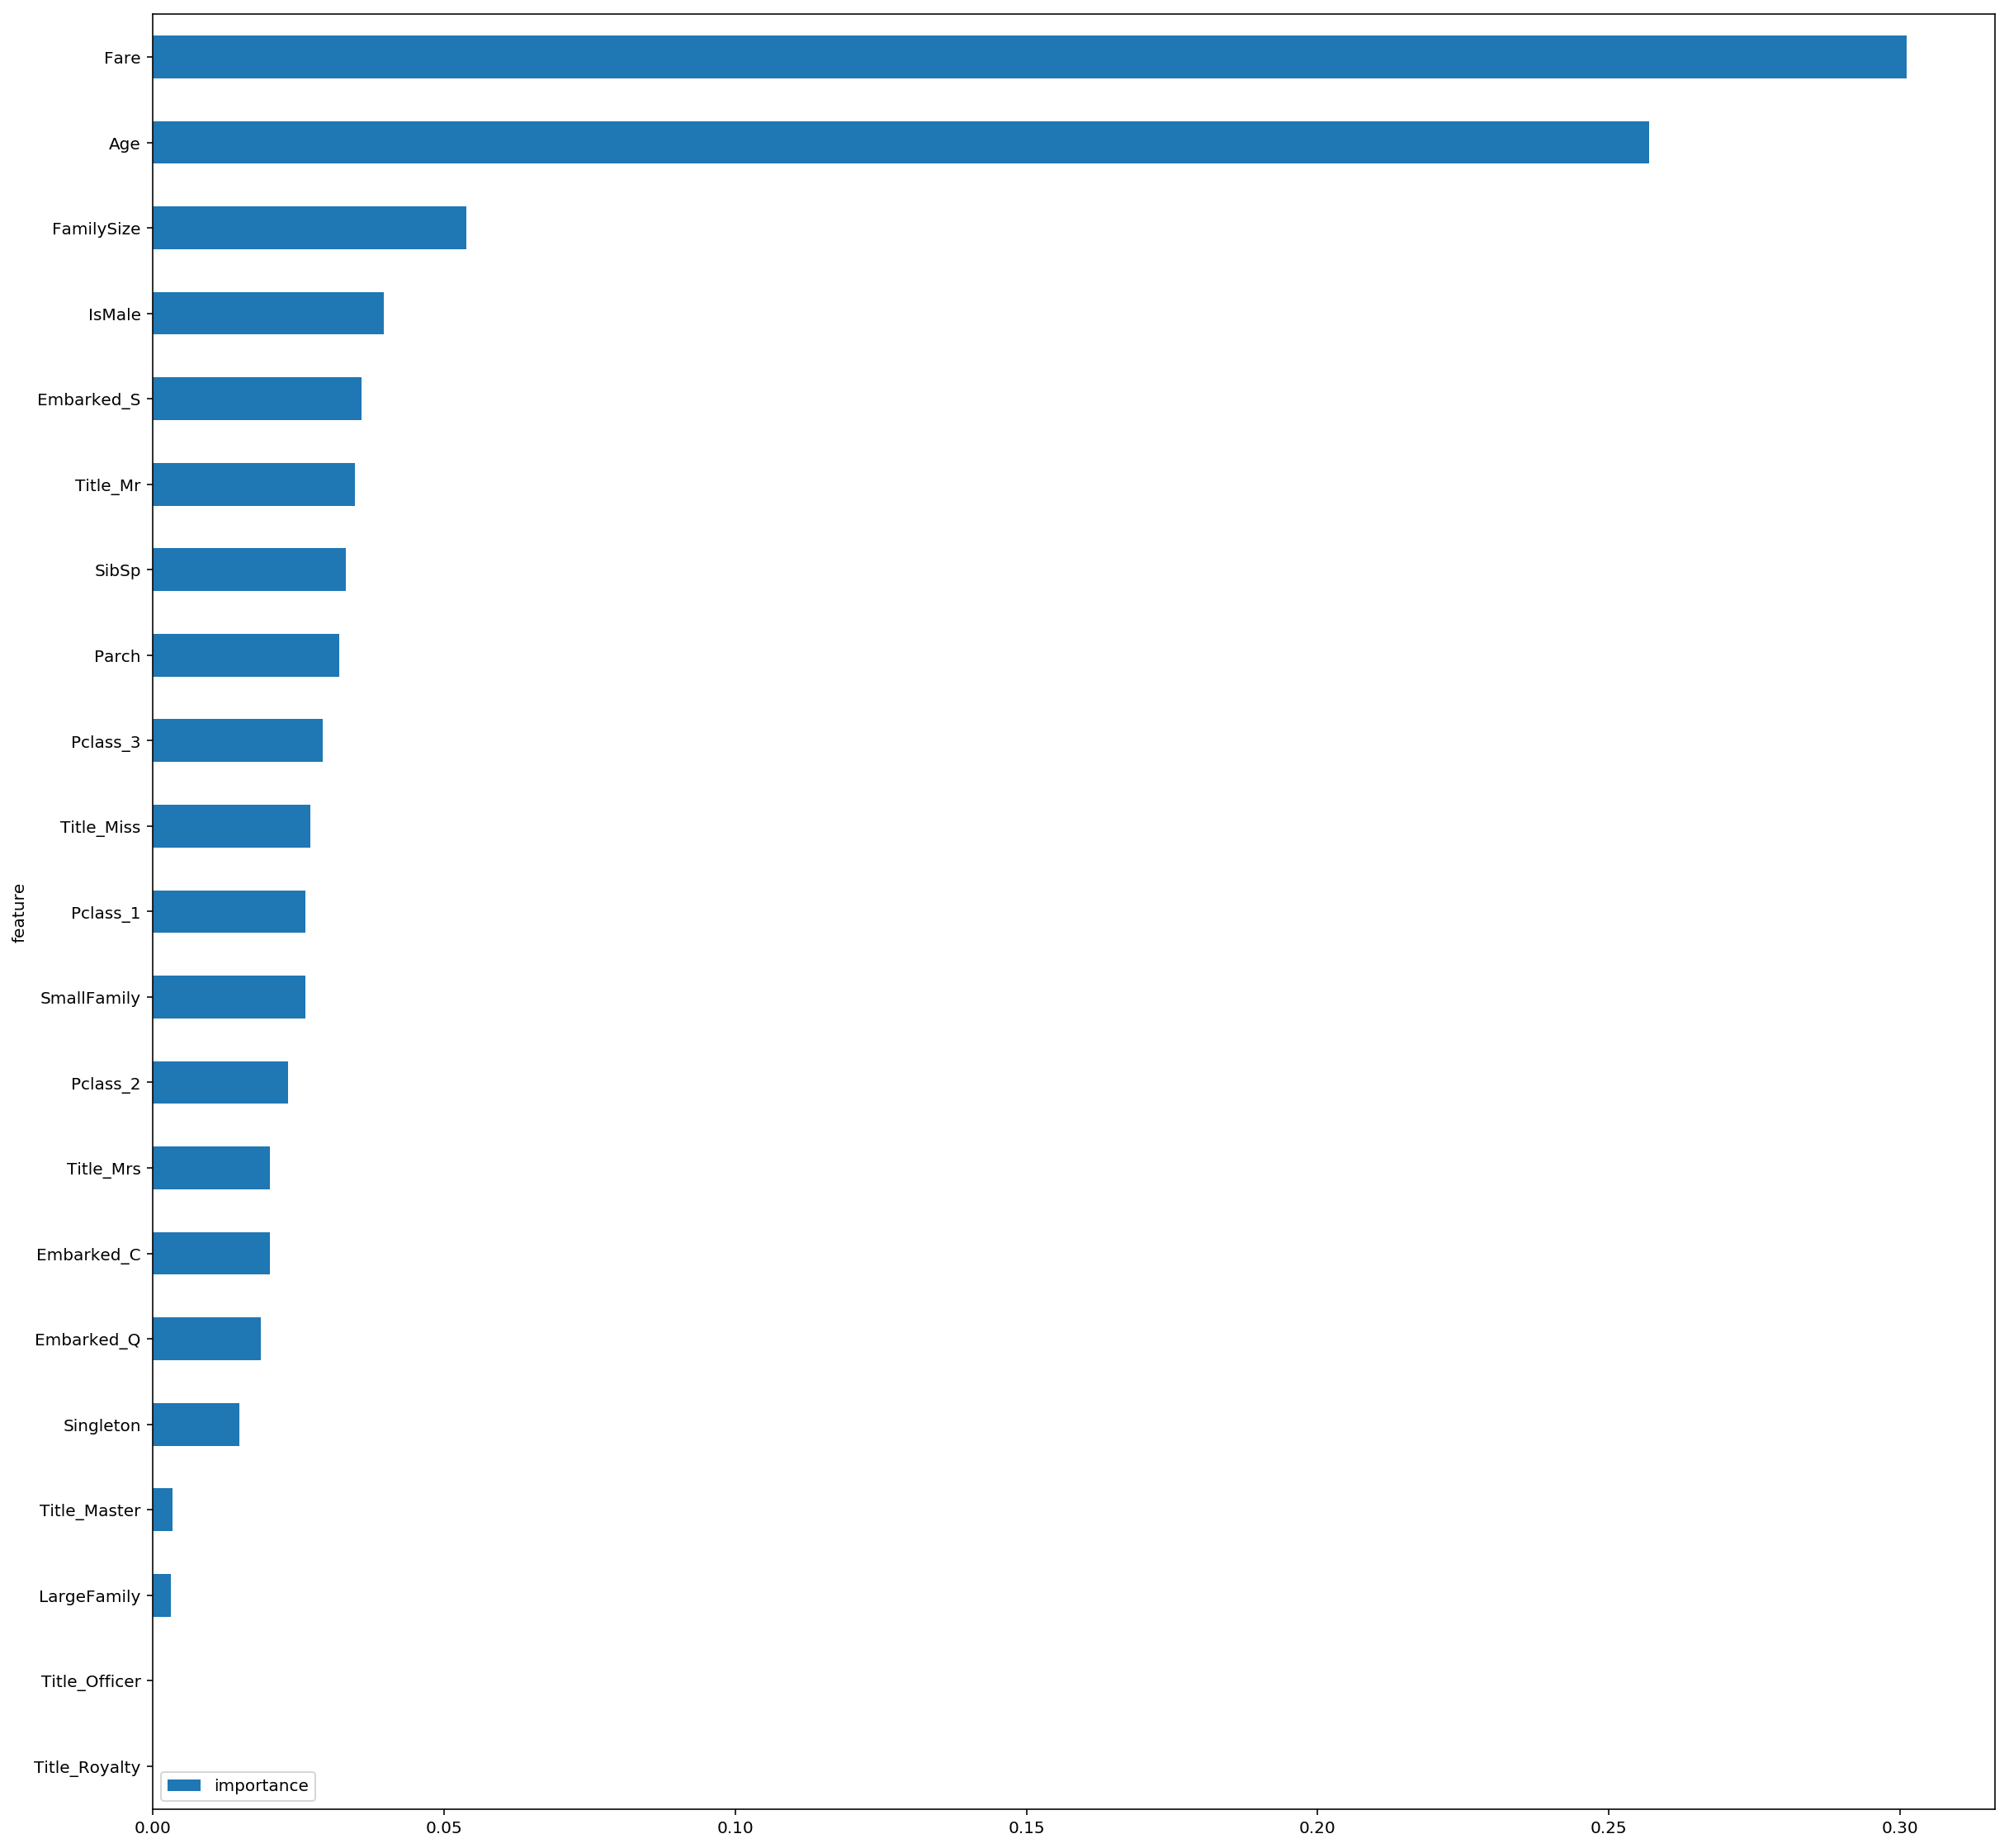

In [26]:
features = pd.DataFrame()
features['feature'] = X_train_i_s.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(20, 20))


In [30]:
model = SelectFromModel(clf, prefit=True,threshold=0.02)
X_train_i_s_r = model.transform(X_train_i_s)

s = X_train_i_s_r.shape[1]

In [31]:
X_train_i_s_r = pd.DataFrame(X_train_i_s_r, columns=X_train_i_s.columns[:s])
X_test_i_s_r = model.transform(X_test_i_s)
X_test_i_s_r = pd.DataFrame(X_test_i_s_r, columns=X_train_i_s.columns[:s])

In [32]:
best_xgboost_clf = get_xgboost_best_model(X_train_i_s_r, y_train,'accuracy')

Best score 1 (accuracy):0.8181818181818182 
Fitting 2 folds for each of 21 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    5.3s finished


Best score 2 (accuracy):0.8316498316498316 
Best score 3 (accuracy):0.8271604938271605 
Best score 4 (accuracy):0.8316498316498316 
Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.7s finished


Best score 5 (accuracy):0.8327721661054994 
Best score 6:  0.842888093918


In [33]:
clf = xgboost.XGBClassifier(**best_xgboost_clf)
clf.fit(X_train_i_s_r,y_train)
y_test = clf.predict(X_test_i_s_r)
submit = pd.DataFrame(test.PassengerId)
submit['Survived'] = y_test
submit.to_csv('submit.csv', index = False)
clf.score(X_train_i_s_r,y_train)

0.89001122334455662

# HyperOpt

In [241]:
hp.quniform('max_depth', 1, 10, 1)

In [277]:
# в этой функции мы проверяем, как ведёт себя модель при заданных параметрах
def score(params):
    #print("Training with params : ")
    #print(params)
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    clf = xgboost.XGBClassifier(**params)
    #accurs = []
    aucs = []
    # Для оценки качества используем KFold, который определили выше
    for train_idx, test_idx in cv.split(X_train_i_s):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        clf.fit(X_train_fold, y_train_fold)
        preds = clf.predict_proba(X_test_fold)
        auc = roc_auc_score(y_test_fold, preds[:, 1])
        aucs.append(auc)
        #accur = clf.score(X_test_fold, y_test_fold)
        #accurs.append(accur)
    auc = np.mean(aucs)
    result = {'loss':  auc, 'status': STATUS_OK}
    print(result)
    return result


# это наша главная функция, в которой мы задаём параметры
def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 500, 50), # (название параметра, от, до, шаг)
             'learning_rate' : hp.quniform('learning_rate', 0.005, 0.03, 0.005),
             'max_depth' : hp.quniform('max_depth', 1, 10, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.1),
             'gamma' : hp.quniform('gamma', 0.0, 0.5, 0.1),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.1),
             'objective': 'reg:linear',
             'silent' : 1,
             'scale_pos_weight': hp.quniform('scale_pos_weight', 0.5, 2, 0.5),
             'reg_alpha': 0.0,
             'reg_lambda': hp.quniform('reg_lambda', 0.01, 0.02, 0.005),
             }

    best = fmin( score, space, algo=tpe.suggest, trials=trials, max_evals=1)
    print('Best: ')
    print(best)

#сюда будет записана
trials = Trials()

optimize(trials)

{'loss': 0.88408057022436615, 'status': 'ok'}
Best: 
{'colsample_bytree': 0.5, 'gamma': 0.4, 'learning_rate': 0.03, 'max_depth': 10.0, 'min_child_weight': 4.0, 'n_estimators': 300.0, 'reg_lambda': 0.01, 'scale_pos_weight': 1.0, 'subsample': 0.8}


In [278]:
best_params_7 = trials.best_trial

In [244]:
my_trials  = trials

In [245]:
my_max = 1
my_num = 0
for i in my_trials:
    tmp = i['result']['loss']
    if tmp <  my_max:
        my_num = i['tid']
        my_max = tmp
my_num

93

In [246]:
best_params_7 = trials.trials[my_num]['misc']['vals']
best_params_7
best_params_8 = best_params_7.copy()
best_params_8

{'colsample_bytree': [0.8],
 'gamma': [0.4],
 'learning_rate': [0.005],
 'max_depth': [1.0],
 'min_child_weight': [3.0],
 'n_estimators': [300.0],
 'reg_lambda': [0.01],
 'scale_pos_weight': [1.5],
 'subsample': [0.9]}

In [247]:
best_params_8['colsample_bytree'] = float(best_params_8['colsample_bytree'][0])
best_params_8['gamma'] = float(best_params_8['gamma'][0])
best_params_8['learning_rate'] = float(best_params_8['learning_rate'][0])
best_params_8['max_depth'] = int(best_params_8['max_depth'][0])
best_params_8['min_child_weight'] = int(best_params_8['min_child_weight'][0])
best_params_8['n_estimators'] = int(best_params_8['n_estimators'][0])
best_params_8['scale_pos_weight'] = float(best_params_8['scale_pos_weight'][0])
best_params_8['reg_lambda'] = float(best_params_8['reg_lambda'][0])
best_params_8['subsample'] = float(best_params_8['subsample'][0])
best_params_8

{'colsample_bytree': 0.8,
 'gamma': 0.4,
 'learning_rate': 0.005,
 'max_depth': 1,
 'min_child_weight': 3,
 'n_estimators': 300,
 'reg_lambda': 0.01,
 'scale_pos_weight': 1.5,
 'subsample': 0.9}

In [248]:
clf = xgboost.XGBClassifier(**best_params_8)
clf.fit(X_train_i_s,y_train)
clf.score (X_train_i_s, y_train)

0.78226711560044893

Создаем сабмит

In [519]:
clf = xgboost.XGBClassifier(**best_xgboost_clf)
clf.fit(X_train_i_s,y_train)
y_test = clf.predict(X_test_i_s)
submit = pd.DataFrame(test.PassengerId)
submit['Survived'] = y_test
submit.tail()
submit.to_csv('submit.csv', index = False)

In [19]:
def get_xgboost_best_model(X_train,y_train, score_type, ones_ratio = 1):
    # посчитаем соотношение между классами
    ones_ratio = y_train[y_train == 1].shape[0] * 1.0 / y_train[y_train == 0].shape[0] 
    """ 
    Шаг 1: Зафиксируем learning_rate и параметры дерева и подберём n_estimators¶

    Параметры:
    
    max_depth. Как указанов в таблице выше, обычно варьируется в интервале от 3 до 10 
        (но от задачи к задаче значения могут меняться). В качестве начального значения обычно используют 5
    min_child_weight. Если выборка сильно несбалансирована, то лучше выбрать значение "1". 
        Иначе лучше выбрать значение "2" и зафиксировать
    gamma. Обычно выставляют значение в интервале от 0 до 0.2 и фиксируют. 
        В дальнейшем этот параметр всегда можно затюнить отдельно
    subsample, colsample_bytree. Выставим 0.8 и зафиксируем. 
        Можно также проварьировать в интервале 0.5-0.9.
    scale_pos_weight. Выставляется в зафисимости от соотношения классов в выборке и фиксируется
    """
    param_grid = {
        # параметры ансамбля
        #'n_estimators': [10, 30, 50, 100, 200, 400, 600, 1000],
        'n_estimators': [400, 600, 1000, 1200],
        'learning_rate': [0.1, ],
        
        # параметры дерева
        'max_depth': [5],
        'min_child_weight': [2],
        'gamma': [0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'scale_pos_weight': [ones_ratio],
        
        # параметры регуляризации
        'reg_alpha': [0.0],
        'reg_lambda': [1.0]
    }

    cv = KFold(n_splits=2, shuffle=True)

    clf = xgboost.XGBClassifier()
    gs = GridSearchCV(clf, param_grid, scoring=score_type, cv=cv, verbose=0)

    gs.fit(X_train, y_train)
    best_params_1 = gs.best_estimator_.get_params()
    print('Best score 1 ({0}):{1} '.format(score_type, gs.best_score_))    
    #print('Best params: ', best_params_1)

    """
    Шаг 2. Подбираем параметры дерева

        max_depth - будем варьировать от 3 до 10 с шагом 2
        min_child_weight - от 1 до 6 с шагом 2

    """

    param_grid = {
        'max_depth': range(3, 10, 1),
        'min_child_weight': range(1, 6, 2)
    }

    clf = xgboost.XGBClassifier(**best_params_1) # в качестве отправной точки возьмём модель с наилучшими параметрами предыдущего шага

    gs = GridSearchCV(clf, param_grid, scoring=score_type, cv=cv, verbose=1)

    gs.fit(X_train, y_train)
    best_params_2 = gs.best_estimator_.get_params()
    print('Best score 2 ({0}):{1} '.format(score_type, gs.best_score_))

    #print('Best params: ', best_params_2)
    
    """
    Шаг 3. Подбираем gamma (критерий создания поддерева)
        gamma - от 0 до 0.5 с шагом 0.1
    """

    param_grid = {
        'gamma': [0.1*i for i in range(6)]
    }

    clf = xgboost.XGBClassifier(**best_params_2)
    gs = GridSearchCV(clf, param_grid, scoring=score_type, cv=cv, verbose=0)
    gs.fit(X_train, y_train)
    best_params_3 = gs.best_estimator_.get_params()
    print('Best score 3 ({0}):{1} '.format(score_type, gs.best_score_))
    #print('Best params: ', best_params_3)

    """
    Шаг 4. Затюним subsample и colsample_bytree¶

    subsample - от 0.5 до 1.0 с шагом 0.1
    colsample_bytree - от 0.5 до 1.0 с шагом 0.1
    """

    param_grid = {
        'subsample': [0.5 + 0.1*i for i in range(6)],
        'colsample_bytree': [0.5 + 0.1*i for i in range(6)]
    }

    clf = xgboost.XGBClassifier(**best_params_3)

    gs = GridSearchCV(clf, param_grid, scoring=score_type, cv=cv, verbose=0)

    gs.fit(X_train, y_train)
    best_params_4 = gs.best_estimator_.get_params()
    print('Best score 4 ({0}):{1} '.format(score_type, gs.best_score_))

    #print('Best params: ', best_params_4)
    
    """
    Шаг 5. Регуляризация
    reg_alpha [1e-5, 1e-2, 0.1, 1, 100]
    reg_lambda [1e-5, 1e-2, 0.1, 1, 100]
    """
    param_grid = {
        'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
        'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
    }

    clf = xgboost.XGBClassifier(**best_params_4)

    gs = GridSearchCV(clf, param_grid, scoring=score_type, cv=cv, verbose=1)

    gs.fit(X_train, y_train)
    best_params_5 = gs.best_estimator_.get_params()
    print('Best score 5 ({0}):{1} '.format(score_type, gs.best_score_))

    #print('Best params: ', best_params_5)
    
    """
    Шаг 6. Learning rate

    Чем меньше у нас n_estimators в ансамбле, тем быстрее нам нужно двигаться с каждым шагом 
    (добавлением нового классификатора), т.е. делать больший learning_rate. 
    Обычно learning rate варьируют так, чтобы произведение n_estimators x learning_rate оставалось инвариантным
    """
    best_params_6 = best_params_5.copy()
    clf = xgboost.XGBClassifier(**best_params_5)
    best_n_estimators = clf.get_params()['n_estimators'] # возьмём наилучшие значения n_estimators с предыдущего шага
    best_learning_rate = clf.get_params()['learning_rate'] # аналогичная запись
    invariant_composition = best_n_estimators * best_learning_rate
    n_estimators_range = [10, 30, 100, 200, 400, 600, 800, 1000, 1200, 1400]

    best_score = gs.best_score_ # возьмём наилучшее качество с предыдущего шага

    for n_estimators in n_estimators_range:
        learning_rate = invariant_composition / n_estimators
        clf.set_params(n_estimators=n_estimators, learning_rate=learning_rate)
        #aucs = []
        accurs = []
        for train_idx, test_idx in cv.split(X_train):
            X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
            clf.fit(X_train_fold, y_train_fold)
            #preds = clf.predict_proba(X_test_fold)
            #auc = roc_auc_score(y_test_fold, preds[:, 1])
            #aucs.append(auc)
            accur = clf.score(X_test_fold, y_test_fold)
            accurs.append(accur)
        accur = np.mean(accurs)
        if accur > best_score:
            best_n_estimators = n_estimators
            best_learning_rate = learning_rate
            best_score = accur
    
    best_params_6['n_estimators'] = best_n_estimators
    best_params_6['learning_rate'] = best_learning_rate

    print('Best score 6: ', best_score)
    
    return best_params_6

In [12]:
def get_gboost_best_model(X_train,y_train, score_type,N_est = 200):
    ones_ratio = y_train[y_train == 1].shape[0] * 1.0 / y_train[y_train == 0].shape[0] 
    param_grid = {
        # параметры ансамбля
        'n_estimators': [50, 100, 200, 400],
        #'n_estimators': [N_est],
        'max_depth' : [5],
        'warm_start' : [True],
        'max_features' : ['sqrt','log2',0.5, 0.7]
    }
    cv = KFold(n_splits=2, shuffle=True)

    clf = GradientBoostingClassifier()
    gs = GridSearchCV(clf, param_grid, scoring=score_type, cv=cv, verbose=0)
    gs.fit(X_train,y_train)
    
    best_params = gs.best_estimator_.get_params()
    print('Best score 1 ({0}):{1} '.format(score_type, gs.best_score_))

    # subsample 
    
    param_grid = {
        'subsample' : [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    clf = GradientBoostingClassifier(**best_params)
    gs = GridSearchCV(clf, param_grid, scoring = score_type, cv=cv, verbose=0)
    gs.fit(X_train, y_train)
    print('Best score subsample ({0}):{1} '.format(score_type, gs.best_score_))

    best_params = gs.best_estimator_.get_params()

    
    # max_depth
    
    param_grid = {
        'max_depth' : range(3,10)
    }
    clf = GradientBoostingClassifier(**best_params)
    gs = GridSearchCV(clf, param_grid, scoring = score_type, cv=cv, verbose=0)
    gs.fit(X_train, y_train)
    print('Best score max_depth ({0}):{1} '.format(score_type, gs.best_score_))

    best_params = gs.best_estimator_.get_params()
    

    # learning_rate
    
    param_grid = {
        'learning_rate' : [0.01,0.03, 0.05, 0.07, 0.09, 0.11]
    }
    clf = GradientBoostingClassifier(**best_params)
    gs = GridSearchCV(clf, param_grid, scoring = score_type, cv=cv, verbose=0)
    gs.fit(X_train, y_train)
    print('Best score learning_rate ({0}):{1} '.format(score_type, gs.best_score_))

    best_params = gs.best_estimator_.get_params()
    return best_params

In [ ]:
 GradientBoostingClassifier()

In [11]:
def get_titles(df):
    
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)

In [10]:
def process_age(df):
    
    grouped = df.groupby(['Sex','Pclass','Title'])
    grouped_median = grouped.median()

    #grouped_test = df.iloc[891:].groupby(['Sex','Pclass','Title'])
    #grouped_median_test = grouped_test.median()       
    # a function that fills the missing values of the Age variable
    
    def fillAges(row, grouped_median):
        if row['Sex']=='female' and row['Pclass'] == 1:
            if row['Title'] == 'Miss':
                return grouped_median.loc['female', 1, 'Miss']['Age']
            elif row['Title'] == 'Mrs':
                return grouped_median.loc['female', 1, 'Mrs']['Age']
            elif row['Title'] == 'Officer':
                return grouped_median.loc['female', 1, 'Officer']['Age']
            elif row['Title'] == 'Royalty':
                return grouped_median.loc['female', 1, 'Royalty']['Age']

        elif row['Sex']=='female' and row['Pclass'] == 2:
            if row['Title'] == 'Miss':
                return grouped_median.loc['female', 2, 'Miss']['Age']
            elif row['Title'] == 'Mrs':
                return grouped_median.loc['female', 2, 'Mrs']['Age']

        elif row['Sex']=='female' and row['Pclass'] == 3:
            if row['Title'] == 'Miss':
                return grouped_median.loc['female', 3, 'Miss']['Age']
            elif row['Title'] == 'Mrs':
                return grouped_median.loc['female', 3, 'Mrs']['Age']

        elif row['Sex']=='male' and row['Pclass'] == 1:
            if row['Title'] == 'Master':
                return grouped_median.loc['male', 1, 'Master']['Age']
            elif row['Title'] == 'Mr':
                return grouped_median.loc['male', 1, 'Mr']['Age']
            elif row['Title'] == 'Officer':
                return grouped_median.loc['male', 1, 'Officer']['Age']
            elif row['Title'] == 'Royalty':
                return grouped_median.loc['male', 1, 'Royalty']['Age']

        elif row['Sex']=='male' and row['Pclass'] == 2:
            if row['Title'] == 'Master':
                return grouped_median.loc['male', 2, 'Master']['Age']
            elif row['Title'] == 'Mr':
                return grouped_median.loc['male', 2, 'Mr']['Age']
            elif row['Title'] == 'Officer':
                return grouped_median.loc['male', 2, 'Officer']['Age']

        elif row['Sex']=='male' and row['Pclass'] == 3:
            if row['Title'] == 'Master':
                return grouped_median.loc['male', 3, 'Master']['Age']
            elif row['Title'] == 'Mr':
                return grouped_median.loc['male', 3, 'Mr']['Age']
    
    df.Age = df.apply(lambda r : fillAges(r, grouped_median) if np.isnan(r['Age']) 
                                                      else r['Age'], axis=1)
    
    #df.iloc[891:].Age = df.iloc[891:].apply(lambda r : fillAges(r, grouped_median_test) if np.isnan(r['Age']) 
     #                                                 else r['Age'], axis=1)
    

In [9]:
def process_ticket(df):
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    df['Ticket'] = df['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(df['Ticket'], prefix='Ticket')
    df = pd.concat([df, tickets_dummies], axis=1)
    df.drop('Ticket', inplace=True, axis=1)

In [8]:
def process_family(df):

    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5<=s else 0)


In [7]:
def process_cabin(df):

    # replacing missing cabins with U (for Uknown)
    df.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c : c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')
    
    df = pd.concat([df,cabin_dummies], axis=1)
    
    df.drop('Cabin', axis=1, inplace=True)


In [6]:
def cross_val_predict_proba(estimator, X_train, y_train, X_test, random_state=None, n_splits=2):
    y_test = np.zeros((len(X_test), n_splits), np.float32)
    
    kfold = KFold(n_splits=n_splits, 
                  shuffle=True,
                  random_state=random_state)

    y_predict = np.zeros_like(y_train, np.float32)
    for i, (train_idx, test_idx) in enumerate(kfold.split(y_train)):
        estimator.fit(X_train[train_idx], y_train[train_idx])
        y_predict[test_idx] = estimator.predict_proba(X_train[test_idx])[:, 1]
        y_test[:, i] = estimator.predict_proba(X_test)[:, 1]
    
    return y_predict, np.mean(y_test, axis=1)